# Part 5- Balancing the Data

Created by Peter Stewart (building on the previous parts of the project)

__About Part 5__

During the course of the project it became apparent looking at the data that it was highly imbalanced, meaning that there were far more of the majority class than the minority class. Since the real objective of the model is to detect the minority class (predicting credit default), it became apparent that the model could benefit from balancing by either oversampling or undersampling our training data. Below, let's continue to improve our modle by exploring the effects of balancing the data.

In [1]:
# Importing our modules and settings and loading our data from part 1 and 2

import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from time import time
import featuretools as ft
import warnings
import pickle
import woodwork as ww
from scipy.stats import t
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [20]:
# Load data from part I
DATA_DIR = "./Data/home-credit-default-risk"

with open(f"{DATA_DIR}/datasets.pkl", 'rb') as n:
    datasets = pickle.load(n)

with open(f"{DATA_DIR}/X_train_FT.pkl", 'rb') as r:
    X_train_FT = pickle.load(r)

with open(f"{DATA_DIR}/X_test_FT.pkl", 'rb') as e:
    X_test_FT = pickle.load(e)

with open(f"{DATA_DIR}/X_train_MF.pkl", 'rb') as mr:
    X_train_MF = pickle.load(mr)

with open(f"{DATA_DIR}/X_test_MF.pkl", 'rb') as me:
    X_test_MF = pickle.load(me)

In [21]:
#Get rid of duplicate columns (basically the original data cols)
kp_list = (X_train_FT.columns.difference(X_train_MF.columns))
print(len(kp_list))
kp_list

1080


Index(['COUNT(bureau_balance_FT)', 'COUNT(cash_FT)', 'COUNT(credit_FT)',
       'COUNT(installments_FT)', 'COUNT(previous_FT)',
       'MAX(bureau_FT.AMT_ANNUITY)', 'MAX(bureau_FT.AMT_CREDIT_MAX_OVERDUE)',
       'MAX(bureau_FT.AMT_CREDIT_SUM)', 'MAX(bureau_FT.AMT_CREDIT_SUM_DEBT)',
       'MAX(bureau_FT.AMT_CREDIT_SUM_LIMIT)',
       ...
       'SUM(previous_FT.DAYS_LAST_DUE)',
       'SUM(previous_FT.DAYS_LAST_DUE_1ST_VERSION)',
       'SUM(previous_FT.DAYS_TERMINATION)',
       'SUM(previous_FT.HOUR_APPR_PROCESS_START)',
       'SUM(previous_FT.NFLAG_INSURED_ON_APPROVAL)',
       'SUM(previous_FT.NFLAG_LAST_APPL_IN_DAY)',
       'SUM(previous_FT.RATE_DOWN_PAYMENT)',
       'SUM(previous_FT.RATE_INTEREST_PRIMARY)',
       'SUM(previous_FT.RATE_INTEREST_PRIVILEGED)',
       'SUM(previous_FT.SELLERPLACE_AREA)'],
      dtype='object', length=1080)

In [22]:
# We should get a matching number and empty list below proving that test and train FT sets have same cols.
kp_list_tst = (X_test_FT.columns.difference(X_test_MF.columns))
print(len(kp_list))
print(kp_list_tst.difference(kp_list))

1080
Index([], dtype='object')


In [23]:
# combine train datasets for ML train set
X_train = X_train_MF.merge(X_train_FT[kp_list], left_index=True, right_index=True, how='outer')
print(X_train.shape)

(307511, 1299)


In [24]:
# This will be our "Set-Aside" copy since this test set doesn't contain tagets we can't use to train the model, only to submit for Kaggle score.
X_test_SA = X_test_MF.merge(X_test_FT[kp_list], left_index=True, right_index=True, how='outer')
print(X_test_SA.shape)

(48744, 1298)


In [25]:
X_train.drop('SK_ID_CURR', axis=1, inplace=True)
print(X_train.shape)
X_test_SA.drop('SK_ID_CURR', axis=1, inplace=True)
print(X_test_SA.shape)

(307511, 1298)
(48744, 1297)


In [6]:
# Here we define the preprocessing pipelines for our data
BL_num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

BL_cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

MNB_num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant',fill_value= 0)),
        ('scaler', MinMaxScaler()),
    ])

new_num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant',fill_value= 0)),
        ('scaler', MinMaxScaler()),
    ])

sm_cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

sm_num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
    ])

In [26]:
# split out the target column to creat y values
y_train = X_train['TARGET']
X_train = X_train.loc[:, ~X_train.columns.isin(['TARGET'])]
print(X_train.shape)
X_train.head()

(307511, 1297)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,SUM(previous_FT.DAYS_LAST_DUE),SUM(previous_FT.DAYS_LAST_DUE_1ST_VERSION),SUM(previous_FT.DAYS_TERMINATION),SUM(previous_FT.HOUR_APPR_PROCESS_START),SUM(previous_FT.NFLAG_INSURED_ON_APPROVAL),SUM(previous_FT.NFLAG_LAST_APPL_IN_DAY),SUM(previous_FT.RATE_DOWN_PAYMENT),SUM(previous_FT.RATE_INTEREST_PRIMARY),SUM(previous_FT.RATE_INTEREST_PRIVILEGED),SUM(previous_FT.SELLERPLACE_AREA)
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,-25.0,125.0,-17.00,9.0,0.0,1.0,0.000000,0.0,0.0,500.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,-3163.0,-3013.0,-3142.00,44.0,2.0,3.0,0.150091,0.0,0.0,1599.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,-724.0,-694.0,-714.00,5.0,0.0,1.0,0.212008,0.0,0.0,30.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,1642297.5,824256.0,1642335.75,132.0,0.0,9.0,1.470709,0.0,0.0,8048.0
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,432817.2,-5023.2,432862.80,74.0,3.6,6.0,0.957098,0.0,0.0,2455.0


In [27]:
# create train test and valid sets from X and Y train data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
#Now let's determine which features are categorical or numerical for our X_train dataset
numerical_at = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_at = X_train.select_dtypes(include=['object', 'bool']).columns


In [29]:
# check to make sure our cat/num lists have all the columns from original dataset
# make sure all categorical data is string type
X_train[categorical_at]=X_train[categorical_at].astype(str)
X_test[categorical_at]=X_test[categorical_at].astype(str)
X_valid[categorical_at]=X_valid[categorical_at].astype(str)
X_test_SA[categorical_at]=X_test_SA[categorical_at].astype(str)
tot_from_above = (len(numerical_at)+len(categorical_at))
print (X_train.shape[1])
print (X_test.shape[1])
print (X_valid.shape[1])
print (tot_from_above)
X_train.info()

1297
1297
1297
1297
<class 'pandas.core.frame.DataFrame'>
Int64Index: 209107 entries, 35339 to 212146
Columns: 1297 entries, NAME_CONTRACT_TYPE to SUM(previous_FT.SELLERPLACE_AREA)
dtypes: float64(1233), int64(44), object(20)
memory usage: 2.0+ GB


In [9]:
#Run our X_train through the column transformer to store the input number and check the output
data_pipeline = ColumnTransformer(transformers=[
       ("num_pipeline", new_num_pipeline, numerical_at),
       ("cat_pipeline", BL_cat_pipeline, categorical_at)],
       remainder='drop',
        n_jobs=1
   )

X_train_transformed = data_pipeline.fit_transform(X_train)

column_names = list(numerical_at) + list(data_pipeline.transformers_[1][1].named_steps["ohe"].get_feature_names(categorical_at))
# print(column_names)
display(pd.DataFrame(X_train_transformed,  columns=column_names).head())
number_of_inputs = X_train_transformed.shape[1]

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,ApprovedorRejected_x_0,ApprovedorRejected_x_Approved,ApprovedorRejected_y_0,ApprovedorRejected_y_Refused,ACTIVE_CLOSED_SUM_BUREAU_x_0,ACTIVE_CLOSED_SUM_BUREAU_x_ACTIVE,ACTIVE_CLOSED_SUM_BUREAU_y_0,ACTIVE_CLOSED_SUM_BUREAU_y_CLOSED
0,0.105263,0.008783,0.123596,0.113535,0.133333,0.282797,0.797238,0.038258,0.791168,0.684313,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.052632,0.014795,0.428742,0.180139,0.388889,0.336758,0.689684,0.037863,0.928852,0.440461,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.000000,0.008115,0.029146,0.044124,0.033333,0.136490,0.064713,1.000000,0.487573,0.395026,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.000000,0.003106,0.056180,0.053995,0.066667,0.421848,0.365953,0.033240,0.663862,0.684452,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.000000,0.013125,0.333611,0.147701,0.297778,0.421848,0.913078,0.042066,0.835625,0.791719,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## Experimenting with Balancing

In [14]:
# First we can get a baseline on the dataset 
# below sections modified from https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

lr = LogisticRegression()

lr.fit(X_train_transformed, y_train.ravel())

X_test_transformed = data_pipeline.fit_transform(X_test)

predictions = lr.predict(X_test_transformed)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     42410
           1       0.32      0.21      0.25      3717

    accuracy                           0.90     46127
   macro avg       0.63      0.59      0.60     46127
weighted avg       0.88      0.90      0.89     46127



In the above output we see a high accuracy but a very low recall for our target value, indicating that our model is not very good at guessing our target variable correctly. Since our whole goal here is to predict the target variable based on our column values, this training data isn't doing the job right now.

In [15]:
#Let's try Smote to balance the dataset by oversampling our minority value for target.
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_transformed, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 16737
Before OverSampling, counts of label '0': 192370 

After OverSampling, the shape of train_X: (384740, 1431)
After OverSampling, the shape of train_y: (384740,) 

After OverSampling, counts of label '1': 192370
After OverSampling, counts of label '0': 192370


In [16]:
#Now that our sample numbers are the same let's check our classification numbers again.
lr1 = LogisticRegression()
lr1.fit(X_train_res, y_train_res.ravel())
predictions = lr1.predict(X_test_transformed)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.47      0.63     42410
           1       0.12      0.83      0.21      3717

    accuracy                           0.50     46127
   macro avg       0.55      0.65      0.42     46127
weighted avg       0.90      0.50      0.60     46127



Now we are getting a higher recall number for our target. Even thought our overall accuracy number is much lower we know that our model is now doing a better job predicting our target so this should perform better at our goal of predicting bad debt with new data where the target is unknown. Next we can try undersampling the majority class and see how this compares.

In [23]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
nr = NearMiss()
  
X_train_miss, y_train_miss = nr.fit_resample(X_train_transformed, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 16737
Before Undersampling, counts of label '0': 192370 

After Undersampling, the shape of train_X: (33474, 1431)
After Undersampling, the shape of train_y: (33474,) 

After Undersampling, counts of label '1': 16737
After Undersampling, counts of label '0': 16737


In [24]:
lr2 = LogisticRegression()
lr2.fit(X_train_miss, y_train_miss.ravel())
predictions = lr2.predict(X_test_transformed)
  
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.46      0.62     42410
           1       0.09      0.59      0.15      3717

    accuracy                           0.47     46127
   macro avg       0.51      0.53      0.38     46127
weighted avg       0.86      0.47      0.58     46127



With undersampling the majority class we end up with a much smaller dataset and the resulting recall value for the target is not as good as what we saw with Smote. Still an improvement but less so, which may be a result of using much less data to create the model. Now we can move forward with recreating our experiment log with our best ML models using Smote to oversample the minority class.

## Rerun ML Pipelines with Smote

In [18]:

pipeline = Pipeline([
        ('dpipe', data_pipeline),
        ('smote', SMOTE(random_state = 42)),
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),

])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainRec  = recall_score(y_train, pipeline.predict(X_train))
validRec  = recall_score(y_valid, pipeline.predict(X_valid))
testRec  = recall_score(y_test, pipeline.predict(X_test))
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])

# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainRec", "TestRec","ValidationRec", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainRec*100:8.2f}%",f"{testRec*100:8.2f}%",f"{validRec*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "MLPClass pipeline full data, relu, lbfgs",]

experimentLog

,Pipeline,RunTime,TrainRec,TestRec,ValidationRec,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,567.0047,64.90%,63.06%,58.50%,74.73%,73.36%,72.77%,"MLPClass pipeline full data, relu, lbfgs"


As a point of comparison let's see if we get different results using smote before the pipeline.

In [25]:
X_train_transformed = data_pipeline.fit_transform(X_train)
X_test_transformed = data_pipeline.fit_transform(X_test)
X_valid_transformed = data_pipeline.fit_transform(X_valid)

X_train_smt, y_train_smt = sm.fit_resample(X_train_transformed, y_train.ravel())

print(X_train_smt.shape)
print(y_train_smt.shape)
print(X_test_transformed.shape)
print(X_valid_transformed.shape)
print(y_valid.shape)
print(y_test.shape)

(384740, 1431)
(384740,)
(46127, 1431)
(52277, 1429)
(52277,)
(46127,)


In [39]:
X_train_transformed = data_pipeline.fit_transform(X_train)
X_test_transformed = data_pipeline.fit_transform(X_test)
X_valid_transformed = data_pipeline.fit_transform(X_valid)

X_train_smt, y_train_smt = sm.fit_resample(X_train_transformed, y_train.ravel())

pipeline = Pipeline([
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),

])

t0 = time()
pipeline.fit(X_train_smt, y_train_smt)
run_time = (time() - t0)
trainRec  = recall_score(y_train_smt, pipeline.predict(X_train_smt))
# validRec  = recall_score(y_valid, pipeline.predict(X_valid_transformed))
testRec  = recall_score(y_test, pipeline.predict(X_test_transformed))
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test_transformed)[:, 1])
train_Auc = roc_auc_score(y_train_smt, pipeline.predict_proba(X_train_smt)[:, 1])
# valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid_transformed)[:,1])

# del experimentLog
try: experimentLog
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainRec", "TestRec","ValidationRec", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline MLPClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainRec*100:8.2f}%",f"{testRec*100:8.2f}%",f"NA",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"NA", "smote first MLPC pipeline full data, relu, lbfgs",]

experimentLog

,Pipeline,RunTime,TrainRec,TestRec,ValidationRec,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,567.004700,64.90%,63.06%,58.50%,74.73%,73.36%,72.77%,"MLPClass pipeline full data, relu, lbfgs"
1,Baseline MLPClassifier with 1431 inputs,502.593306,77.84%,57.22%,NA,82.18%,73.04%,NA,"smote first MLPC pipeline full data, relu, lbfgs"


This does give us a better recall and area under the curve score for the training data but it doesn't seem to transfer to a better prediction of the unseen test data. Also we are getting an odd result with our validation set and had to leave that scoring blank using this process. Let's try another way to organize our pipeline, this time we need to do our categorical data transform first, then resample with smote, then use our scalar and do our modeling. This should give us a result that fits our experiment and we can use that method to create a submission to generate a score from the kaggle competition and see if it ultimately improves over our previous best score.

In [10]:
smote_pipeline = ColumnTransformer(transformers=[
       ("num_pipeline", sm_num_pipeline, numerical_at),
       ("cat_pipeline", sm_cat_pipeline, categorical_at)],
       remainder='drop',
        n_jobs=1
   )


In [42]:

pipeline = Pipeline([
        ('dpipe', smote_pipeline),
        ('smote', SMOTE(random_state = 42)),
        ('scaler', MinMaxScaler()),
        ('MLP', MLPClassifier(activation= 'relu', solver = 'lbfgs', random_state=42)),
])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainRec  = recall_score(y_train, pipeline.predict(X_train))
validRec  = recall_score(y_valid, pipeline.predict(X_valid))
testRec  = recall_score(y_test, pipeline.predict(X_test))
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])

# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainRec", "TestRec","ValidationRec", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline LogRegClassifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainRec*100:8.2f}%",f"{testRec*100:8.2f}%",f"{validRec*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "smote pipe, MLPC, relu, lbfgs",]

experimentLog

,Pipeline,RunTime,TrainRec,TestRec,ValidationRec,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,567.004700,64.90%,63.06%,58.50%,74.73%,73.36%,72.77%,"MLPClass pipeline full data, relu, lbfgs"
1,Baseline MLPClassifier with 1431 inputs,502.593306,77.84%,57.22%,NA,82.18%,73.04%,NA,"smote first MLPC pipeline full data, relu, lbfgs"
2,Baseline MLPClassifier with 1431 inputs,545.572944,49.30%,48.96%,49.14%,73.81%,73.47%,73.46%,"smote pipe, MLPC, relu, lbfgs"


In [43]:
pipeline = Pipeline([
        ('dpipe', smote_pipeline),
        ('smote', SMOTE(random_state = 42)),
        ('scaler', MinMaxScaler()),
        ('logistic', LogisticRegression(penalty='l2', C  = 10000.0, solver='newton-cg'))
])

t0 = time()
pipeline.fit(X_train, y_train)
run_time = (time() - t0)
trainRec  = recall_score(y_train, pipeline.predict(X_train))
validRec  = recall_score(y_valid, pipeline.predict(X_valid))
testRec  = recall_score(y_test, pipeline.predict(X_test))
test_Auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
train_Auc = roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1])
valid_Auc = roc_auc_score(y_valid, pipeline.predict_proba(X_valid)[:,1])

# del experimentLog
try: experimentLog 
except : experimentLog = pd.DataFrame(columns=["Pipeline", "RunTime", "TrainRec", "TestRec","ValidationRec", 
                                               "Train_Auc", "Test_Auc", "Valid_Auc", "Description",])
experimentLog.loc[len(experimentLog)] =[f"Baseline LogReg Classifier with {number_of_inputs} inputs", run_time ,
                                        f"{trainRec*100:8.2f}%",f"{testRec*100:8.2f}%",f"{validRec*100:8.2f}%",
                                        f"{train_Auc*100:8.2f}%",f"{test_Auc*100:8.2f}%",f"{valid_Auc*100:8.2f}%", "smote pipe, logreg, l2, C:10000",]

experimentLog



,Pipeline,RunTime,TrainRec,TestRec,ValidationRec,Train_Auc,Test_Auc,Valid_Auc,Description
0,Baseline MLPClassifier with 1431 inputs,567.004700,64.90%,63.06%,58.50%,74.73%,73.36%,72.77%,"MLPClass pipeline full data, relu, lbfgs"
1,Baseline MLPClassifier with 1431 inputs,502.593306,77.84%,57.22%,NA,82.18%,73.04%,NA,"smote first MLPC pipeline full data, relu, lbfgs"
2,Baseline MLPClassifier with 1431 inputs,545.572944,49.30%,48.96%,49.14%,73.81%,73.47%,73.46%,"smote pipe, MLPC, relu, lbfgs"
3,Baseline MLPClassifier with 1431 inputs,5130.320178,69.98%,67.58%,67.17%,77.62%,76.31%,76.54%,"smote pipe, logreg, l2, C:10000"


In [44]:
#Backing up the data to make it easier to restart the kernel if neccesary

with open(f'{DATA_DIR}/X_train_p5.pkl', 'wb') as a:
    pickle.dump(X_train, a)

with open(f'{DATA_DIR}/X_test_p5.pkl', 'wb') as b:
    pickle.dump(X_test, b)

with open(f'{DATA_DIR}/y_train_p5.pkl', 'wb') as c:
    pickle.dump(y_train, c)

with open(f'{DATA_DIR}/y_test_p5.pkl', 'wb') as d:
    pickle.dump(y_test, d)

with open(f'{DATA_DIR}/X_valid_p5.pkl', 'wb') as e:
    pickle.dump(X_valid, e)

with open(f'{DATA_DIR}/y_valid_p5.pkl', 'wb') as f:
    pickle.dump(y_valid, f)

with open(f'{DATA_DIR}/X_test_SA_p5.pkl', 'wb') as g:
    pickle.dump(X_test_SA, g)

with open(f'{DATA_DIR}/exp_log_p5.pkl', 'wb') as h:
    pickle.dump(experimentLog, h)



In [4]:
with open(f"{DATA_DIR}/X_train_p5.pkl", 'rb') as aa:
    X_train = pickle.load(aa)

with open(f"{DATA_DIR}/X_test_p5.pkl", 'rb') as bb:
    X_test = pickle.load(bb)

with open(f"{DATA_DIR}/y_train_p5.pkl", 'rb') as cc:
    y_train = pickle.load(cc)

with open(f"{DATA_DIR}/y_test_p5.pkl", 'rb') as dd:
    y_test = pickle.load(dd)

with open(f"{DATA_DIR}/X_valid_p5.pkl", 'rb') as ee:
    X_valid = pickle.load(ee)

with open(f"{DATA_DIR}/y_valid_p5.pkl", 'rb') as ff:
    y_valid = pickle.load(ff)

with open(f"{DATA_DIR}/X_test_SA_p5.pkl", 'rb') as gg:
    X_test_SA = pickle.load(gg)

with open(f"{DATA_DIR}/exp_log_p5.pkl", 'rb') as hh:
    experimentLog = pickle.load(hh)

# Submission

In [34]:

sa_pipeline = Pipeline([
        ('dpipe', smote_pipeline),
        ('scaler', MinMaxScaler())
])
X_test_SA_trans = sa_pipeline.fit_transform(X_test_SA)
X_test_SA_trans.shape

(48744, 1428)

In [35]:
X_train_transformed.shape

(209107, 1431)

In [37]:
pipeline = Pipeline([
        ('dpipe', smote_pipeline),
        ('smote', SMOTE(random_state = 42)),
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(penalty='l2', C  = 10000.0, solver='newton-cg'))
])


model = pipeline.fit(X_train, y_train)
# test_class_scores = (model.predict_proba(X_test_SA)[:,1])
pred_class_scores = (model.predict(X_test_SA))


In [38]:
print(len(pred_class_scores))
print(pred_class_scores.sum())

48744
13997


In [39]:
# Submission dataframe
submit_df = datasets["application_test"][['SK_ID_CURR']]
submit_df['TARGET'] = pred_class_scores

submit_df.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,1
2,100013,0
3,100028,0
4,100038,1


In [40]:
submit_df.to_csv("./Data/submission_bal_lr.csv",index=False)

In [41]:
prob_class_scores = (model.predict_proba(X_test_SA)[:,1])

In [42]:
submit_df = datasets["application_test"][['SK_ID_CURR']]
submit_df['TARGET'] = prob_class_scores

submit_df.head()

,SK_ID_CURR,TARGET
0,100001,0.307568
1,100005,0.715740
2,100013,0.403997
3,100028,0.247708
4,100038,0.636576


In [43]:
submit_df.to_csv("./Data/submission_bal_prob_lr.csv",index=False)

![submission.png]( 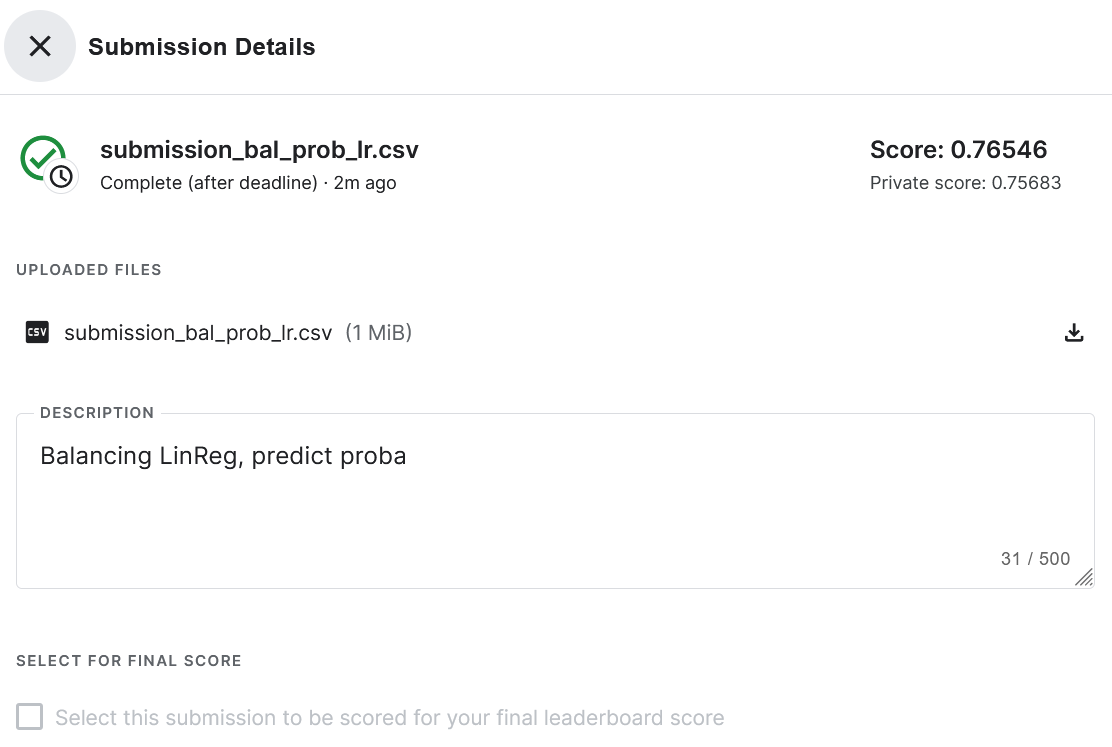)

__Conclusion Part 5__

The section above shows how to impliment oversampling with Smote in order to create an artificial balance between the target class and other data. We can see that using this approach yeilded an improvement in our model's ability to classify on unknown data by about 2 percentage points. This approach seemed to be more effective than undersampling the non-target data using Nearmiss, but both approaches may be useful depending ont he problem and the dataset used for modeling. This finding does lend support to the argument that unbalanced datasets can take away from the effectiveness of the model and should be assesed and corrected for.